# compose visualisations of listener experience, Case Study 2¶


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import librosa
from IPython.display import Audio
import mir_eval.sonify
from pydub import AudioSegment
from matplotlib.transforms import ScaledTranslation


from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport rp2

In [3]:
 %reload_ext autoreload

In [4]:
def Part_maps(Entries):
    parts_on = {}
    cols = Entries.columns
    for c in cols:
        if Entries[c].isna().sum()>1:
            Entries.loc[Entries[c].notna(),['mm',c]]
            V = Entries.loc[Entries[c].notna(),['mm',c]]
            parts_on[c]=V.rename(columns = {c:'Playing'})
            D = pd.DataFrame(index = parts_on[c].index )
            for i in D.index:
                if parts_on[c].loc[i,'Playing'] == 1.0:
                    D[i] = D.index-i
            D[D>=0] = np.nan
            D['Pre'] = D.max(axis=1)
            D.loc[parts_on[c].loc[:,'Playing'] == 1.0,'Pre'] = 0.0
            parts_on[c]['Pre'] = D['Pre']
            parts_on[c]['Post'] = parts_on[c]['Pre'].diff()
            parts_on[c].loc[parts_on[c]['Post']<=0,'Post'] = 0.0
            parts_on[c][parts_on[c].isna()] = 0.0
    return parts_on
def resp_shade(ax,breaths,cat,colour):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Period_T'], facecolor=colour,alpha = 0.2)
    return

def resp_shaded(ax,breaths,cat,colour,alph = 0.4):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Insp_T'], facecolor=colour,alpha = alph )
        ax.axvspan(r['Ex'],r['Ex']+r['Exp_T'], facecolor=colour,alpha = alph - 0.2)
    return

def quickcarresp(Breaths):
    Insp_seq = Breaths.copy()#.query('In > @xlim[0] and In < @xlim[1]').copy().reset_index(drop=True)
    Insp_seq.loc[:,'dPT'] = np.log(Insp_seq['Period_T']/Insp_seq['Period_T'].shift(1)).abs()
    Insp_seq.loc[:,'dIT'] = np.log(Insp_seq['Insp_T']/Insp_seq['Insp_T'].shift(1)).abs()
    Insp_seq.loc[:,'dID'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].shift(1)).abs()
    Insp_seq.loc[:,'relD'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].rolling(5,center=True).median()).abs()
    
    depth_thresh = Insp_seq['IDepth'].median()*2
    low_D =  Insp_seq['IDepth'].quantile(0.25)
    mD =  Insp_seq['IDepth'].median()
    mT =  Insp_seq['Period_T'].median() 
    mIT =  Insp_seq['Insp_T'].median()
    
    Insp_seq['Categories']='Disturbed'

    V =  Insp_seq.query('Insp_T>0.5 and Period_T>2 and IDepth<3*@low_D and IE_Ratio>0.2 and dPT<0.5 and dID<0.5')
    Insp_seq.loc[V.index,'Categories']='Quiet'
    
    return Insp_seq

def minT(timestamps,timepoints):
    df = pd.DataFrame(index=timestamps,columns=['minT'],data = 0.0)
    for i in timestamps:
        df.loc[i,'minT']=(timepoints-i).abs().min()
    return df

## KORK data

In [5]:
# audio file locations in
data_loc = './data/'
mydpi = 196

In [11]:
Pentries = pd.read_csv(data_loc +'Performance_data/PlayTimings_KORK2024_Sae1.csv') 
concert = 'C1_Sae1'
buff = 10
s_time = -buff #C_times.loc[0,concert]
e_time = Pentries[concert].iloc[-1]+buff
dur = (e_time - s_time)-2*buff
ev = {}
ev['Event'] = 'Kjempeviseslåtten'
ev['Related'] = 'Sae1'

In [14]:
piece = ev['Related']
Pstructures = Pentries.loc[Pentries['Structure'].notna(),:]
Pthemes = Pentries.loc[Pentries['Theme'].notna(),:]
Prehearse = Pentries.loc[Pentries['RehNo'].notna(),:]
key_annotations = pd.read_csv(data_loc + 'Annotations/Case2_densenotes.csv')
QOM_key_annotations = key_annotations.loc[[16,17,26,27],:].copy()
Resp_key_annotations = key_annotations.loc[[ 0, 2, 5,  7,  8,  9, 11, 13, 15,
       18, 20, 21, 22, 23, 24, 25,  28, 29, 30],:].copy()
Psustains = pd.read_csv(data_loc + 'Performance_data/K1_Sae1_sustains.csv')
Pentries

,S_1,RehNo,Structure,Theme,mm,Conductor,Flute_1,Flute_2,Oboe_1,Oboe_2,...,Va_solo,Viola,Vc_Solo,Cello,Contrabass,C1_Sae1,C1_Sae2,RD_Sae1,RD_Sae2,RR_Saev
0,1.019501,0.0,Intro,NaN,1.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.019501,0.019501,0.019501,-0.003900,-0.003900
1,2.539683,NaN,NaN,a,1.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.539683,1.726893,1.539683,1.492880,1.492880
2,9.204535,NaN,NaN,NaN,2.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.204535,8.181134,7.572698,6.917460,6.543039
3,12.078730,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.078730,10.470295,9.885261,9.300227,9.230023
4,13.670748,NaN,NaN,a,3.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.670748,12.038912,11.407075,10.634830,10.822041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,456.787302,NaN,NaN,NaN,160.75,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,455.787302,442.986757,446.169342,425.318730,412.658594
208,457.227030,NaN,NaN,NaN,161.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,456.227030,443.426485,446.609070,425.758458,413.098322
209,458.109388,NaN,NaN,NaN,161.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,457.109388,444.285442,447.468027,426.594014,413.910476
210,459.067211,NaN,NaN,NaN,162.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,458.067211,445.243265,448.425850,427.551837,414.868299


In [15]:
C_df = pd.read_csv('./outfiles/KORK_Sae1_10_cqt.csv',index_col = 0)
C_df.iloc[:5,:]

,83,82,81,80,79,78,77,76,75,74,...,9,8,7,6,5,4,3,2,1,0
-10.000,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.976,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.952,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.927,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.903,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0


In [27]:
# labels and categories
palettes = ['c','m','g','r','b','k'] # instrument playing time shading
respcats = ['Disturbed','Quiet']
palette={'Disturbed':'c','Quiet':'lightblue'} # respiration categories
PartPalette = {'Case2_Play1':'k','Case2_Play2':'grey','Conductor_Play1':'orange'}
recs_labels = {'Conductor_Play1':'Conductor','Case2_Play1':'Aud 1st play','Case2_Play2':'Aud 2nd play*',}

pitchticks = np.arange(7,84,12)
pitchticklabels=['C1','C2','C3','C4','C5','C6','C7']

In [26]:
# Sensor measurements
dfeats = {}
Breathings = {}
for rec in ['Case2_Play1','Case2_Play2','Conductor_Play1']:
    dfeats[rec] = pd.read_csv(data_loc + 'Physiological_data/'+rec+'_Feats.csv',index_col=0)
    if rec.endswith('2'):
        dfeats[rec].set_index('Time_1',inplace=True)
    Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(dfeats[rec].loc[:,'Resp_wave']),dfeats[rec].loc[:,'Resp_wave'])
    Insp_seq = quickcarresp(Breaths)
    Breathings[rec] = quickcarresp(Breaths).copy()
    R = (dfeats[rec].loc[:,'Resp_wave']-dfeats[rec].loc[:,'Resp_wave'].median())/Insp_seq['IDepth'].quantile(0.15)
    dfeats[rec].loc[:,'Resp_wave'] = R
recs = list(dfeats.keys())

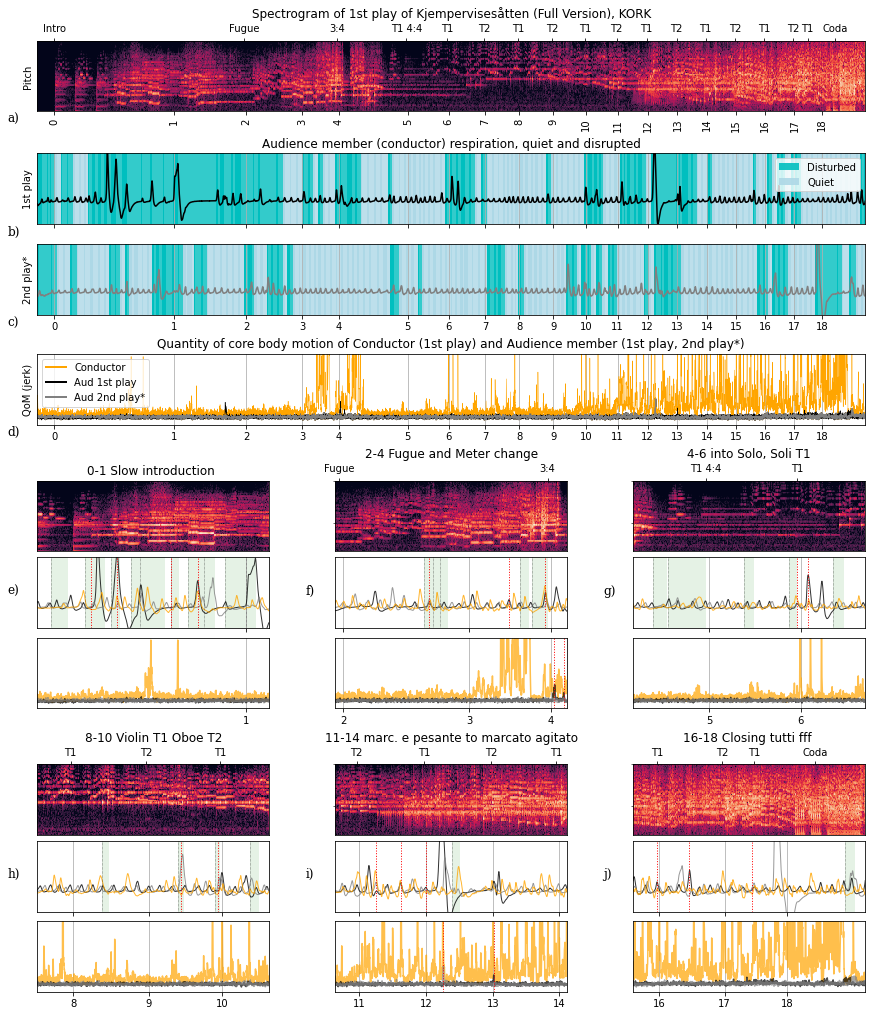

In [29]:
fig3 = plt.figure(constrained_layout=True,figsize=(12,14))
gs = fig3.add_gridspec(10, 3)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
axes[1] = fig3.add_subplot(gs[1, :])
axes[2] = fig3.add_subplot(gs[2, :])
axes[3] = fig3.add_subplot(gs[3, :])
axes[4] = fig3.add_subplot(gs[4,0])
axes[5] = fig3.add_subplot(gs[5,0])
axes[6] = fig3.add_subplot(gs[6,0])
axes[7] = fig3.add_subplot(gs[4,1])
axes[8] = fig3.add_subplot(gs[5,1])
axes[9] = fig3.add_subplot(gs[6,1])
axes[10] = fig3.add_subplot(gs[4,2])
axes[11] = fig3.add_subplot(gs[5,2])
axes[12] = fig3.add_subplot(gs[6,2])
axes[13] = fig3.add_subplot(gs[7,0])
axes[14] = fig3.add_subplot(gs[8,0])
axes[15] = fig3.add_subplot(gs[9,0])
axes[16] = fig3.add_subplot(gs[7,1])
axes[17] = fig3.add_subplot(gs[8,1])
axes[18] = fig3.add_subplot(gs[9,1])
axes[19] = fig3.add_subplot(gs[7,2])
axes[20] = fig3.add_subplot(gs[8,2])
axes[21] = fig3.add_subplot(gs[9,2])

buff=10
resprange = [-7,15]
s_time = -buff
e_time = dur+buff

ax=axes[0]
chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
ax.set(xticks = f(Prehearse.loc[:,'C1_Sae1']),xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.set(yticks=[],ylabel='Pitch') 
ax1 = ax.twiny()
ax1.set(xticks=Pstructures.loc[:,'C1_Sae1'],xticklabels=Pstructures.loc[:,'Structure'],xlim=[s_time,e_time])
ax.set(title='Spectrogram of 1st play of Kjempervisesåtten (Full Version), KORK')

ax=axes[1]
df_feats = dfeats['Case2_Play1'].copy()
Insp_seq = Breathings['Case2_Play1'].copy()
df_feats.loc[:,'Resp_wave'].plot(c=PartPalette['Case2_Play1'],linestyle='-',label="",ax = ax)
ax.set_xlim([s_time,e_time])
for cat in respcats: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
ax.legend(loc='upper right') #loc='upper right'
for cat in respcats: #'Vocal?',
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[-1,dur+1],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=[],xlim=[s_time,e_time])
ax.grid()
ax.set(title='Audience member (conductor) respiration, quiet and disrupted',ylabel='1st play')

ax=axes[2]
df_feats = dfeats['Case2_Play2'].copy()
Insp_seq = Breathings['Case2_Play2'].copy()
df_feats.loc[:,'Resp_wave'].plot(c=PartPalette['Case2_Play2'],linestyle='-',label="",ax = ax)
for cat in respcats: 
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
# ax.legend() #loc='upper right'
for cat in respcats:
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
ax.set(title='',ylabel='2nd play*') #Audience member (conductor) respiration, quiet and disrupted (time-warped)

ax=axes[3]
recs = ['Conductor_Play1','Case2_Play1','Case2_Play2']
for rec in recs:
    df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],linewidth=2,label = recs_labels[rec],ax = ax)
ax.legend(loc='upper left')
for rec in recs:
    df_feats = dfeats[rec].copy()
    df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],linewidth=0.5,ax = ax)
ax.set(ylim=[0,100],xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
ax.set(title = 'Quantity of core body motion of Conductor (1st play) and Audience member (1st play, 2nd play*)', ylabel = 'QoM (jerk)')

resprange = [-5,12]

intervals={
"0-1 Slow introduction ":[15,75],
"2-4 Fugue and Meter change":[109,169],
"4-6 into Solo, Soli T1":[185,245],
"8-10 Violin T1 Oboe T2":[260,320],# "m 107, m 115":[342,362],
"11-14 marc. e pesante to marcato agitato":[320,380],# "m 107, m 115":[342,362],
"16-18 Closing tutti fff ":[405,465]}


excerpts_Label=list(intervals.keys())
for i in range(len(intervals)):
    exc = excerpts_Label[i]
    [s_time,e_time] = intervals[exc]
    
    ax = axes[(i*3)+4]
    chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
    ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Audio'
    ax1 = ax.twiny()
    ax1.set(xticks=Pstructures.loc[:,'C1_Sae1'],xticklabels=Pstructures.loc[:,'Structure'],xlim=[s_time,e_time])
    ax.set_title(exc)

    ax = axes[(i*3)+5]
    recs = ['Case2_Play1','Case2_Play2','Conductor_Play1']
    for rec in recs:
        df_feats = dfeats[rec].copy()
        df_feats.loc[:,'Resp_wave'].plot(c=PartPalette[rec],linewidth = 1,label = rec,alpha=0.8,ax = ax) 
    ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Resp'
    subSus = Psustains.query('TIME<@e_time and TIME>@s_time').copy()
    if len(subSus)>0:
        for j,row in subSus.iterrows():
            ax.axvspan(row['TIME'],row['TIME']+row['DURATION'], facecolor='g',alpha = 0.1)
            ax.plot([row['TIME'],row['TIME']],resprange,linestyle = ':',linewidth=0.5,color='k')  
    tcue_list = Resp_key_annotations.query('TIME<@e_time and TIME>@s_time')
#     print(exc)
#     print(tcue_list)
    for tcue in Resp_key_annotations.loc[tcue_list.index,'TIME']:  ax.plot([tcue, tcue],resprange,linestyle = ':',linewidth=1,color='r')  
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=resprange)
    ax.grid()
    
    recs = ['Conductor_Play1','Case2_Play1','Case2_Play2']
    ax = axes[(i*3)+6]
    for rec in recs:
        df_feats = dfeats[rec].copy()
        df_feats.loc[:,'Jerk'].plot(c=PartPalette[rec],label = rec,alpha = 0.7,ax = ax)
    tcue_list = QOM_key_annotations.query('TIME<@e_time and TIME>@s_time')
#     print(tcue_list)
    for tcue in QOM_key_annotations.loc[tcue_list.index,'TIME']:  ax.plot([tcue, tcue],[0,100],linestyle = ':',linewidth=1,color='r')  
    ax.set(xticks = Prehearse.loc[:,'C1_Sae1'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[],yticklabels=[])
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=[0,100])
    ax.grid()
    
ax_labels = ['a)','b)','c)','d)','','e)','','','f)','','','g)','','','h)','','','i)','','','j)','','','k)','','']
for i in range(len(axes)):
    ax = axes[i]
    label = ax_labels[i]
    if i<4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -85/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
    if i>=4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -40/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')

outplots = './plots/'
figname = '_'.join(['Compound_Excerpts_CaseStudy2.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()

## Phase Categories across audience members to KORK performances of Kjempe....

Note this is demonstrating the processing of respiration recordings not published as part of this data set. 

In [34]:
files = os.listdir('../KORK/Signals/Sae/')
ratios = pd.Series()
for file in files:
    if 'EQRESP' in file:
        if 'AU8' in file:
            partID = file.split('_')[2]
            playN = file[6]
            V = pd.read_csv('../KORK/Signals/Sae/'+file)
            V.set_index('p_sTime',inplace=True)
            Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(V['Breathing']),V['Breathing'])
            Insp_seq = quickcarresp(Breaths)
            Qratio = Insp_seq.query('Categories=="Quiet"').loc[:,'Period_T'].sum()/Insp_seq.loc[:,'Period_T'].sum()
            print([file,Qratio])
            ratios[partID+playN]=Qratio
ratios

['C1_Sae1_AU805_EQRESP.csv', 0.3837676611501373]
Clipped!
['C1_Sae2_AU803_EQRESP.csv', 0.5125663898646995]
['C1_Sae1_AU808_EQRESP.csv', 0.7893364395002282]
['C1_Sae2_AU812_EQRESP.csv', 0.7057800420386957]
['C1_Sae1_AU814_EQRESP.csv', 0.6047678879194882]
['C1_Sae1_AU811_EQRESP.csv', 0.9201994734083767]
Clipped!
['C1_Sae2_AU806_EQRESP.csv', 0.7077588416733179]
['C1_Sae2_AU801_EQRESP.csv', 0.8066166205800138]
['C1_Sae1_AU807_EQRESP.csv', 0.734487399946976]
['C1_Sae2_AU810_EQRESP.csv', 0.8800072210093697]
['C1_Sae1_AU813_EQRESP.csv', 0.22692188349219042]
['C1_Sae2_AU809_EQRESP.csv', 0.8999295710995987]
['C1_Sae2_AU815_EQRESP.csv', 0.6519882755153971]
['C1_Sae2_AU804_EQRESP.csv', 0.8590808786870857]
['C1_Sae1_AU802_EQRESP.csv', 0.6420314388132036]
['C1_Sae1_AU810_EQRESP.csv', 0.5950184878826201]
['C1_Sae1_AU801_EQRESP.csv', 0.6518405661385109]
['C1_Sae2_AU807_EQRESP.csv', 0.7358726252810048]
['C1_Sae1_AU804_EQRESP.csv', 0.8179035145721847]
['C1_Sae2_AU802_EQRESP.csv', 0.5678936114417136]
['

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


AU8051    0.383768
AU8032    0.512566
AU8081    0.789336
AU8122    0.705780
AU8141    0.604768
AU8111    0.920199
AU8062    0.707759
AU8012    0.806617
AU8071    0.734487
AU8102    0.880007
AU8131    0.226922
AU8092    0.899930
AU8152    0.651988
AU8042    0.859081
AU8021    0.642031
AU8101    0.595018
AU8011    0.651841
AU8072    0.735873
AU8041    0.817904
AU8022    0.567894
AU8091    0.804192
AU8132    0.746525
AU8151    0.465281
AU8121    0.566911
AU8082    0.557194
AU8142    0.600896
AU8052    0.427208
AU8031    0.517783
AU8061    0.595772
AU8112    0.626021
dtype: float64

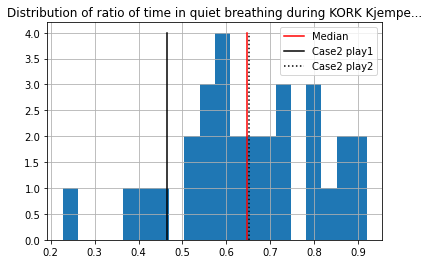

0.6469360024758573

In [36]:
ratios.hist(bins=20)
plt.plot([ratios.median(),ratios.median()],[0,4],'r',label='Median')
plt.plot([ratios['AU8151'],ratios['AU8151']],[0,4],'k',label='Case2 play1')
plt.plot([ratios['AU8152'],ratios['AU8152']],[0,4],':k',label='Case2 play2')
plt.title('Distribution of ratio of time in quiet breathing during KORK Kjempe...')
plt.legend()
plt.show()
ratios.median()

Note the lowest quiet respiration ratios are on files that have complications with respiration measurements where the classification performs particularly badly. Some quirks of the Equivital vest sensors results in poor capture from some bodies. Alternative criteria are being considered. 

['Case2_Play1', 11.948420368637752]
['Case2_Play2', 11.929436644508026]
['Conductor_Play1', 28.41797037647798]


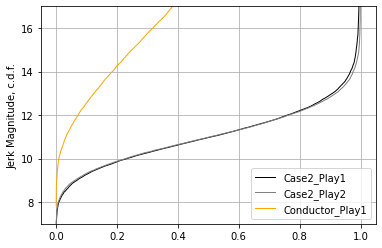

In [23]:
buff = 0
s_time = -buff
e_time = dur+buff

for rec in recs:
    print ([rec,dfeats[rec].loc[s_time:e_time,'Jerk'].quantile(.75)])
    C = pd.Series(dfeats[rec].loc[s_time:e_time,'Jerk']).sort_values().reset_index(drop=True)
    C.index = C.index/len(C)
    C.plot(linewidth=1,c=PartPalette[rec],label = rec)
plt.legend()
plt.ylabel('Jerk Magnitude, c.d.f.')
plt.grid()
plt.ylim([7,17])
plt.show()

Proportionally, the cumulative distribution for magnitude of jerk is marginally higher in this audience participant in the first play than in the second. Both times, the motion is around noise levels but moments of deviation, consistent with rare twitches or adjustments, separate at the extreme (top 20% percentile)